In [1]:
import numpy as np
import pygad
import time
import pandas as pd
import random
from scipy import stats
import gc  # Для очистки памяти
from tqdm import tqdm  # Для отображения прогресса

# Функция Растригина
def rastrigin_function(solution):
    A = 10
    return A * len(solution) + sum([(x ** 2 - A * np.cos(2 * np.pi * x)) for x in solution])

# Определение целевой функции для оптимизации
def fitness_function(ga_instance, solution, solution_idx):
    return -rastrigin_function(solution)  # Для минимизации используем отрицание

# Функция обратного вызова, которая вызывается после каждой итерации
def on_generation(ga_instance):
    current_best_fitness = -ga_instance.best_solution()[1]
    current_generation = ga_instance.generations_completed
    current_time = time.time() - start_time  # Время на текущую итерацию

    # Сохранение данных текущей итерации
    iterations_data.append({
        'generation': current_generation,
        'best_fitness': current_best_fitness,
        'time': current_time,
        'solution': ga_instance.best_solution()[0]  # Сохранение лучшего решения
    })

    print(f"Итерация: {current_generation}, Лучшая пригодность: {current_best_fitness:.6f}, Время на текущую итерацию: {current_time:.2f} секунд")

# Генерация случайных гиперпараметров (один раз в начале)
def generate_random_hyperparameters():
    hyperparameters = {
        "num_parents_mating": random.randint(2, 450),  # От 2 до 2000
        "sol_per_pop": random.randint(100,500),  # Размер популяции от 50 до 3000
        "num_genes": random.randint(5, 30),  # Длина решения
        "mutation_percent_genes": random.uniform(1, 50),  # Процент генов для мутации
        "mutation_num_genes": random.randint(1, 5),  # Количество генов для мутации
        "crossover_type": random.choice(["single_point", "two_points", "uniform", "scattered"]),  # Тип кроссинговера
        "mutation_type": random.choice(["random", "adaptive", "swap", "scramble", "inversion"]),  # Тип мутации
        "mutation_by_replacement": random.choice([True, False]),  # Замена генов
        "random_mutation_min_val": random.uniform(-10, 0),  # Мин. значение мутации
        "random_mutation_max_val": random.uniform(0, 10),  # Макс. значение мутации
        "keep_parents": random.uniform(0, 1)  # Процент родителей, сохраняемых для следующего поколения
    }

    # Гарантируем, что количество родителей для скрещивания меньше или равно числу особей в популяции
    hyperparameters["num_parents_mating"] = min(hyperparameters["num_parents_mating"], hyperparameters["sol_per_pop"])

    # Для адаптивной мутации mutation_num_genes должен быть массивом с двумя элементами
    if hyperparameters["mutation_type"] == "adaptive":
        hyperparameters["mutation_num_genes"] = np.random.randint(1, 5, size=2)  # Два целых числа
    else:
        hyperparameters["mutation_num_genes"] = hyperparameters["mutation_num_genes"]
    
    return hyperparameters

# Количество внешних прогонов с разными гиперпараметрами
num_outer_runs = 30

# Количество прогонов для каждого набора гиперпараметров
num_inner_runs = 30

# Массив для хранения суммарных результатов по каждому внешнему прогону
summary_results = []

# Внешний цикл для разных гиперпараметров с использованием tqdm для отображения прогресса
for outer_run in tqdm(range(num_outer_runs), desc="Outer Runs Progress"):
    print(f"\n=== Внешний прогон {outer_run + 1} с новыми гиперпараметрами ===\n")
    
    # Инициализируем гиперпараметры один раз перед внешним прогоном
    hyperparams = generate_random_hyperparameters()

    # Массив для хранения результатов по каждому внутреннему прогону
    results = []

    # Внутренний цикл для одного набора гиперпараметров
    for run in range(num_inner_runs):
        print(f"\n=== Внутренний прогон {run + 1} ===\n")

        # Очистка данных по итерациям для каждого внутреннего прогона
        iterations_data = []

        # Генерация начальной популяции с учётом диапазонов
        initial_population = np.array([
            [np.random.uniform(-5.12, 5.12) for _ in range(hyperparams["num_genes"])]  # Решение длиной num_genes
            for _ in range(hyperparams["sol_per_pop"])
        ])

        # Настройка генетического алгоритма с одними и теми же гиперпараметрами для всех прогонов
        ga_instance = pygad.GA(
            num_generations=100,  # Используем фиксированное количество поколений
            num_parents_mating=hyperparams["num_parents_mating"],
            fitness_func=fitness_function,
            sol_per_pop=hyperparams["sol_per_pop"],
            num_genes=hyperparams["num_genes"],  # Длина решения как гиперпараметр
            init_range_low=-5.12,
            init_range_high=5.12,
            mutation_percent_genes=hyperparams["mutation_percent_genes"],
            crossover_type=hyperparams["crossover_type"],
            mutation_type=hyperparams["mutation_type"],
            mutation_by_replacement=hyperparams["mutation_by_replacement"],
            mutation_num_genes=hyperparams["mutation_num_genes"] if hyperparams["mutation_type"] != "adaptive" else hyperparams["mutation_num_genes"],  # Массив для adaptive
            random_mutation_min_val=hyperparams["random_mutation_min_val"],
            random_mutation_max_val=hyperparams["random_mutation_max_val"],
            initial_population=initial_population,
            on_generation=on_generation  # Установка обратного вызова
        )

        # Запуск оптимизации
        start_time = time.time()
        ga_instance.run()

        # Поиск лучших итераций
        best_iterations = [d for d in iterations_data if d['best_fitness'] == min([data['best_fitness'] for data in iterations_data])]
        best_iteration = min(best_iterations, key=lambda x: x['time'])

        # Пересчёт функции Растригина для лучших параметров
        best_solution_fitness = rastrigin_function(best_iteration['solution'])

        # Сохранение результатов для текущего внутреннего прогона
        run_data = {
            'Значение функции Растригина': best_solution_fitness,
            'Лучшая итерация': best_iteration['generation'],
            'Время до лучшей итерации': best_iteration['time']
        }
        results.append(run_data)

        # Очистка данных после внутреннего прогона
        iterations_data.clear()  # Очищаем список данных об итерациях
        del ga_instance
        gc.collect()  # Явная очистка памяти после каждого внутреннего прогона

    # Создание таблицы с результатами для одного набора гиперпараметров
    df_results = pd.DataFrame(results)

    # Вычисление медианы для времени и значения функции, моды для лучшей итерации
    median_time = df_results['Время до лучшей итерации'].median()
    median_fitness = df_results['Значение функции Растригина'].median()
    mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]

    # Добавление строки с медианными значениями и гиперпараметрами в итоговую таблицу
    summary_row = {
        'Медиана значения функции Растригина': median_fitness,
        'Мода лучшей итерации': mode_iteration,
        'Медиана времени до лучшей итерации': median_time
    }

    # Добавляем гиперпараметры как отдельные столбцы
    for param, value in hyperparams.items():
        summary_row[param] = value

    summary_results.append(summary_row)

    # Вывод промежуточного результата после каждого внешнего прогона
    print(f"\nСредние значения для внешнего прогона {outer_run + 1}:\n")
    print(pd.DataFrame([summary_row]))

    # Очистка неиспользуемых данных
    del df_results
    gc.collect()

# Создание итоговой таблицы с результатами всех внешних прогонов
df_summary = pd.DataFrame(summary_results)

# Вывод итоговой таблицы
print("\nИтоговая таблица с медианными значениями и гиперпараметрами:")
print(df_summary)


Outer Runs Progress:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



=== Внешний прогон 1 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 294.631720, Время на текущую итерацию: 0.22 секунд
Итерация: 2, Лучшая пригодность: 292.433977, Время на текущую итерацию: 0.44 секунд
Итерация: 3, Лучшая пригодность: 259.291997, Время на текущую итерацию: 0.71 секунд
Итерация: 4, Лучшая пригодность: 235.552288, Время на текущую итерацию: 0.94 секунд
Итерация: 5, Лучшая пригодность: 221.734668, Время на текущую итерацию: 1.16 секунд
Итерация: 6, Лучшая пригодность: 175.642460, Время на текущую итерацию: 1.33 секунд
Итерация: 7, Лучшая пригодность: 153.976079, Время на текущую итерацию: 1.49 секунд
Итерация: 8, Лучшая пригодность: 152.752281, Время на текущую итерацию: 1.70 секунд
Итерация: 9, Лучшая пригодность: 131.927561, Время на текущую итерацию: 1.90 секунд
Итерация: 10, Лучшая пригодность: 131.927561, Время на текущую итерацию: 2.21 секунд
Итерация: 11, Лучшая пригодность: 114.866706, Время на текущую итерацию: 2.5

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:   3%|▎         | 1/30 [08:11<3:57:34, 491.52s/it]


Средние значения для внешнего прогона 1:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             0.238395                    63  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           12.492437                 244          347  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         25               26.312041                   1   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                    False                -0.863997  \

   random_mutation_max_val  keep_parents  
0                 5.079114      0.792307  

=== Внешний прогон 2 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===



c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (inversion). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but ({mutation_type}). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.")
c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. T

Итерация: 1, Лучшая пригодность: 47.813698, Время на текущую итерацию: 0.19 секунд
Итерация: 2, Лучшая пригодность: 29.195506, Время на текущую итерацию: 0.46 секунд
Итерация: 3, Лучшая пригодность: 29.195506, Время на текущую итерацию: 0.67 секунд
Итерация: 4, Лучшая пригодность: 29.195506, Время на текущую итерацию: 0.78 секунд
Итерация: 5, Лучшая пригодность: 29.195506, Время на текущую итерацию: 0.93 секунд
Итерация: 6, Лучшая пригодность: 21.151625, Время на текущую итерацию: 1.12 секунд
Итерация: 7, Лучшая пригодность: 19.705333, Время на текущую итерацию: 1.31 секунд
Итерация: 8, Лучшая пригодность: 15.656420, Время на текущую итерацию: 1.54 секунд
Итерация: 9, Лучшая пригодность: 12.293875, Время на текущую итерацию: 1.75 секунд
Итерация: 10, Лучшая пригодность: 12.293875, Время на текущую итерацию: 1.87 секунд
Итерация: 11, Лучшая пригодность: 12.293875, Время на текущую итерацию: 2.08 секунд
Итерация: 12, Лучшая пригодность: 11.734521, Время на текущую итерацию: 2.20 секунд
И

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:   7%|▋         | 2/30 [16:57<3:58:55, 512.00s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter


Средние значения для внешнего прогона 2:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             0.980335                    34  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           10.643058                 412          412  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0          7                9.111036                   4   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                     True                -1.595921  \

   random_mutation_max_val  keep_parents  
0                 3.030065      0.172064  

=== Внешний прогон 3 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 283.946949, Время на текущую итерацию: 0.15 секунд
Итерация: 2, Лучшая пригодность: 220.679552, Время на текущую итерацию: 0.29 секунд
Итерация: 3, Лучшая пригодность: 200.763913, Время н

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  10%|█         | 3/30 [19:27<2:35:51, 346.34s/it]


Средние значения для внешнего прогона 3:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                           109.399718                    13  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            1.520019                  20          247  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         27               25.734947                   3   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0          swap                    False                 -3.20865  \

   random_mutation_max_val  keep_parents  
0                 2.058986      0.419451  

=== Внешний прогон 4 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 124.119213, Время на текущую итерацию: 0.04 секунд
Итерация: 2, Лучшая пригодность: 115.573221, Время на текущую итерацию: 0.07 секунд
Итерация: 3, Лучшая пригодность: 97.861423, Время на

c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 6, Лучшая пригодность: 87.622728, Время на текущую итерацию: 0.26 секунд
Итерация: 7, Лучшая пригодность: 81.751626, Время на текущую итерацию: 0.30 секунд
Итерация: 8, Лучшая пригодность: 75.643927, Время на текущую итерацию: 0.33 секунд
Итерация: 9, Лучшая пригодность: 75.643927, Время на текущую итерацию: 0.36 секунд
Итерация: 10, Лучшая пригодность: 75.643927, Время на текущую итерацию: 0.44 секунд
Итерация: 11, Лучшая пригодность: 75.643927, Время на текущую итерацию: 0.53 секунд
Итерация: 12, Лучшая пригодность: 75.643927, Время на текущую итерацию: 0.60 секунд
Итерация: 13, Лучшая пригодность: 62.990937, Время на текущую итерацию: 0.69 секунд
Итерация: 14, Лучшая пригодность: 62.990937, Время на текущую итерацию: 0.74 секунд
Итерация: 15, Лучшая пригодность: 62.990937, Время на текущую итерацию: 0.78 секунд
Итерация: 16, Лучшая пригодность: 57.657739, Время на текущую итерацию: 0.82 секунд
Итерация: 17, Лучшая пригодность: 52.385992, Время на текущую итерацию: 0.85 сек

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  13%|█▎        | 4/30 [22:09<1:58:32, 273.57s/it]


Средние значения для внешнего прогона 4:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            18.999314                    73  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            3.978527                 137          137  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         12               12.670512                   1   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                     True                -1.893526  \

   random_mutation_max_val  keep_parents  
0                 1.731733      0.469002  

=== Внешний прогон 5 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===



c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 1, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.26 секунд
Итерация: 2, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.50 секунд
Итерация: 3, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.61 секунд
Итерация: 4, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.71 секунд
Итерация: 5, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.82 секунд
Итерация: 6, Лучшая пригодность: 83.035288, Время на текущую итерацию: 0.93 секунд
Итерация: 7, Лучшая пригодность: 83.035288, Время на текущую итерацию: 1.10 секунд
Итерация: 8, Лучшая пригодность: 77.157145, Время на текущую итерацию: 1.27 секунд
Итерация: 9, Лучшая пригодность: 77.157145, Время на текущую итерацию: 1.42 секунд
Итерация: 10, Лучшая пригодность: 55.628529, Время на текущую итерацию: 1.56 секунд
Итерация: 11, Лучшая пригодность: 55.628529, Время на текущую итерацию: 1.77 секунд
Итерация: 12, Лучшая пригодность: 55.628529, Время на текущую итерацию: 1.90 секунд
И

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]



Средние значения для внешнего прогона 5:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            50.570304                    57  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            8.532053                  74          390  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         10                31.73352                   5        uniform  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                     True                -8.951974  \

   random_mutation_max_val  keep_parents  
0                 4.392424      0.931668  


Outer Runs Progress:  17%|█▋        | 5/30 [29:57<2:23:11, 343.67s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:818: UserWarning: The first element in the 'mutation_num_genes' parameter is 1 which is smaller than the second element 3. This means the mutation rate for the high-quality solutions is higher than the mutation rate of the low-quality ones. This causes high disruption in the high qualitiy solutions while making little changes in the low quality solutions. Please make the first element higher than the second element.
  warnings.warn(f"The first element in the 'mutation_num_genes' parameter is {mutation_num_genes[0]} which is smaller than the second element {mutation_num_genes[1]}. This means the mutation rate for the high-quality solutions is higher than the mutation rate of the low-quality ones. This causes high disruption in the high qualitiy solutions while making little changes in the low quality solutions. Please make the 


=== Внешний прогон 6 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 344.839167, Время на текущую итерацию: 0.37 секунд
Итерация: 2, Лучшая пригодность: 291.702388, Время на текущую итерацию: 0.76 секунд
Итерация: 3, Лучшая пригодность: 243.579751, Время на текущую итерацию: 1.12 секунд
Итерация: 4, Лучшая пригодность: 239.892285, Время на текущую итерацию: 1.43 секунд
Итерация: 5, Лучшая пригодность: 198.762371, Время на текущую итерацию: 1.93 секунд
Итерация: 6, Лучшая пригодность: 198.762371, Время на текущую итерацию: 2.23 секунд
Итерация: 7, Лучшая пригодность: 193.084365, Время на текущую итерацию: 2.76 секунд
Итерация: 8, Лучшая пригодность: 174.394484, Время на текущую итерацию: 3.10 секунд
Итерация: 9, Лучшая пригодность: 164.932542, Время на текущую итерацию: 3.50 секунд
Итерация: 10, Лучшая пригодность: 155.240065, Время на текущую итерацию: 3.98 секунд
Итерация: 11, Лучшая пригодность: 140.937517, Время на текущую итерацию: 4.4

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  20%|██        | 6/30 [50:33<4:18:54, 647.25s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter


Средние значения для внешнего прогона 6:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            61.560669                    86  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           32.132207                 274          439  \

   num_genes  mutation_percent_genes mutation_num_genes crossover_type   
0         30                44.28179             [1, 3]   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      adaptive                     True                -2.495589  \

   random_mutation_max_val  keep_parents  
0                 1.429607      0.505673  

=== Внешний прогон 7 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 351.953978, Время на текущую итерацию: 0.07 секунд
Итерация: 2, Лучшая пригодность: 289.967389, Время на текущую итерацию: 0.15 секунд
Итерация: 3, Лучшая пригодность: 224.315546, Время на 

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  23%|██▎       | 7/30 [55:45<3:26:08, 537.78s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (swap). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement paramet


Средние значения для внешнего прогона 7:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            10.249473                   100  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            9.474073                 152          152  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         27               13.506602                   2      scattered  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                    False                -4.598706  \

   random_mutation_max_val  keep_parents  
0                 5.922851      0.366724  

=== Внешний прогон 8 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 258.432755, Время на текущую итерацию: 0.11 секунд
Итерация: 2, Лучшая пригодность: 221.554489, Время на текущую итерацию: 0.24 секунд
Итерация: 3, Лучшая пригодность: 189.770452, Время н

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]



Средние значения для внешнего прогона 8:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            36.991108                    18  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            2.132011                  58          194  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         24                6.614279                   2     two_points  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0          swap                     True                -1.199728  \

   random_mutation_max_val  keep_parents  
0                 9.072024      0.189774  


Outer Runs Progress:  27%|██▋       | 8/30 [58:26<2:33:05, 417.53s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (scramble). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but ({mutation_type}). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.")
c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The '


=== Внешний прогон 9 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 140.161384, Время на текущую итерацию: 0.03 секунд
Итерация: 2, Лучшая пригодность: 115.196665, Время на текущую итерацию: 0.15 секунд
Итерация: 3, Лучшая пригодность: 100.551694, Время на текущую итерацию: 0.27 секунд
Итерация: 4, Лучшая пригодность: 95.555752, Время на текущую итерацию: 0.34 секунд
Итерация: 5, Лучшая пригодность: 72.193518, Время на текущую итерацию: 0.41 секунд
Итерация: 6, Лучшая пригодность: 67.671798, Время на текущую итерацию: 0.49 секунд
Итерация: 7, Лучшая пригодность: 67.671798, Время на текущую итерацию: 0.62 секунд
Итерация: 8, Лучшая пригодность: 67.671798, Время на текущую итерацию: 0.66 секунд
Итерация: 9, Лучшая пригодность: 65.746821, Время на текущую итерацию: 0.70 секунд
Итерация: 10, Лучшая пригодность: 43.479918, Время на текущую итерацию: 0.75 секунд
Итерация: 11, Лучшая пригодность: 43.479918, Время на текущую итерацию: 0.79 секунд

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  30%|███       | 9/30 [1:01:27<2:00:19, 343.81s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' paramet


Средние значения для внешнего прогона 9:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             1.702678                    98  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            3.986539                 124          124  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         13                8.793008                   1      scattered  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      scramble                     True                -5.509493  \

   random_mutation_max_val  keep_parents  
0                 6.348952      0.197761  

=== Внешний прогон 10 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 400.994084, Время на текущую итерацию: 0.18 секунд
Итерация: 2, Лучшая пригодность: 400.994084, Время на текущую итерацию: 0.40 секунд
Итерация: 3, Лучшая пригодность: 393.278823, Время 

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  33%|███▎      | 10/30 [1:09:53<2:11:14, 393.71s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:818: UserWarning: The first element in the 'mutation_num_genes' parameter is 3 which is smaller than the second element 4. This means the mutation rate for the high-quality solutions is higher than the mutation rate of the low-quality ones. This causes high disruption in the high qua


Средние значения для внешнего прогона 10:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                           342.024844                    11  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            7.113057                 218          218  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         30                5.252967                   2   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                    False                -5.134285  \

   random_mutation_max_val  keep_parents  
0                 9.680145       0.83173  

=== Внешний прогон 11 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 190.123388, Время на текущую итерацию: 0.12 секунд
Итерация: 2, Лучшая пригодность: 190.123388, Время на текущую итерацию: 0.32 секунд
Итерация: 3, Лучшая пригодность: 190.123388, Время

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  37%|███▋      | 11/30 [1:17:57<2:13:25, 421.36s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parame


=== Внешний прогон 12 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 40.224362, Время на текущую итерацию: 0.05 секунд
Итерация: 2, Лучшая пригодность: 32.416194, Время на текущую итерацию: 0.10 секунд
Итерация: 3, Лучшая пригодность: 26.364161, Время на текущую итерацию: 0.17 секунд
Итерация: 4, Лучшая пригодность: 16.132131, Время на текущую итерацию: 0.24 секунд
Итерация: 5, Лучшая пригодность: 16.132131, Время на текущую итерацию: 0.38 секунд
Итерация: 6, Лучшая пригодность: 16.132131, Время на текущую итерацию: 0.49 секунд
Итерация: 7, Лучшая пригодность: 16.132131, Время на текущую итерацию: 0.59 секунд
Итерация: 8, Лучшая пригодность: 12.191327, Время на текущую итерацию: 0.77 секунд
Итерация: 9, Лучшая пригодность: 12.191327, Время на текущую итерацию: 0.88 секунд
Итерация: 10, Лучшая пригодность: 9.105226, Время на текущую итерацию: 0.94 секунд
Итерация: 11, Лучшая пригодность: 6.150439, Время на текущую итерацию: 0.98 секунд
Ите

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  40%|████      | 12/30 [1:22:26<1:52:28, 374.94s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:818: UserWarning: The first element in the 'mutation_num_genes' parameter is 2 which is smaller than the second element 3. This means the mutation rate for the high-quality solutions is higher than the mutation rate of the low-quality ones. This causes high disruption in the high qua


Средние значения для внешнего прогона 12:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             2.654963                    81  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            7.413072                  93          329  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0          6                38.19415                   1   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                    False                -6.766727  \

   random_mutation_max_val  keep_parents  
0                 0.433825      0.695524  

=== Внешний прогон 13 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 37.094179, Время на текущую итерацию: 0.07 секунд
Итерация: 2, Лучшая пригодность: 37.094179, Время на текущую итерацию: 0.14 секунд
Итерация: 3, Лучшая пригодность: 37.094179, Время на

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  43%|████▎     | 13/30 [1:27:05<1:38:00, 345.88s/it]


=== Внешний прогон 14 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.11 секунд


c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 2, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.23 секунд
Итерация: 3, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.32 секунд
Итерация: 4, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.40 секунд
Итерация: 5, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.49 секунд
Итерация: 6, Лучшая пригодность: 247.322462, Время на текущую итерацию: 0.61 секунд
Итерация: 7, Лучшая пригодность: 230.969878, Время на текущую итерацию: 0.76 секунд
Итерация: 8, Лучшая пригодность: 230.969878, Время на текущую итерацию: 0.86 секунд
Итерация: 9, Лучшая пригодность: 230.969878, Время на текущую итерацию: 0.94 секунд
Итерация: 10, Лучшая пригодность: 230.969878, Время на текущую итерацию: 1.00 секунд
Итерация: 11, Лучшая пригодность: 230.969878, Время на текущую итерацию: 1.05 секунд
Итерация: 12, Лучшая пригодность: 230.969878, Время на текущую итерацию: 1.11 секунд
Итерация: 13, Лучшая пригодность: 230.969878, Время на текущую итерацию: 

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  47%|████▋     | 14/30 [1:31:11<1:24:14, 315.88s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parame


Средние значения для внешнего прогона 14:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                           178.416493                    25  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            4.915549                 128          128  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         21                2.366012                   1   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                    False                -6.480214  \

   random_mutation_max_val  keep_parents  
0                 0.823571      0.097127  

=== Внешний прогон 15 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 214.568768, Время на текущую итерацию: 0.07 секунд
Итерация: 2, Лучшая пригодность: 203.450162, Время на текущую итерацию: 0.21 секунд
Итерация: 3, Лучшая пригодность: 191.150647, Время

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  50%|█████     | 15/30 [1:36:39<1:19:52, 319.51s/it]


Средние значения для внешнего прогона 15:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             1.430296                   100  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            9.294098                 165          165  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         19               29.134105                   5        uniform  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      scramble                    False                -7.602121  \

   random_mutation_max_val  keep_parents  
0                 7.256935      0.143672  

=== Внешний прогон 16 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===



c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 1, Лучшая пригодность: 378.669500, Время на текущую итерацию: 0.15 секунд
Итерация: 2, Лучшая пригодность: 353.089675, Время на текущую итерацию: 0.50 секунд
Итерация: 3, Лучшая пригодность: 353.089675, Время на текущую итерацию: 0.70 секунд
Итерация: 4, Лучшая пригодность: 337.305446, Время на текущую итерацию: 0.89 секунд
Итерация: 5, Лучшая пригодность: 336.052561, Время на текущую итерацию: 1.00 секунд
Итерация: 6, Лучшая пригодность: 313.981022, Время на текущую итерацию: 1.19 секунд
Итерация: 7, Лучшая пригодность: 270.589977, Время на текущую итерацию: 1.50 секунд
Итерация: 8, Лучшая пригодность: 266.265288, Время на текущую итерацию: 1.61 секунд
Итерация: 9, Лучшая пригодность: 250.323968, Время на текущую итерацию: 1.73 секунд
Итерация: 10, Лучшая пригодность: 250.323968, Время на текущую итерацию: 1.87 секунд
Итерация: 11, Лучшая пригодность: 241.640788, Время на текущую итерацию: 2.10 секунд
Итерация: 12, Лучшая пригодность: 224.857349, Время на текущую итерацию: 2

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  53%|█████▎    | 16/30 [1:45:13<1:28:12, 378.06s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parame


Средние значения для внешнего прогона 16:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            68.106268                    95  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           15.437141                 151          203  \

   num_genes  mutation_percent_genes mutation_num_genes crossover_type   
0         29               11.370938             [4, 1]   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      adaptive                    False                -9.140872  \

   random_mutation_max_val  keep_parents  
0                 8.298467       0.83979  

=== Внешний прогон 17 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 392.580287, Время на текущую итерацию: 0.09 секунд
Итерация: 2, Лучшая пригодность: 392.580287, Время на текущую итерацию: 0.33 секунд
Итерация: 3, Лучшая пригодность: 392.580287, Время н

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  57%|█████▋    | 17/30 [1:52:48<1:26:54, 401.12s/it]


Средние значения для внешнего прогона 17:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                           385.131226                     1  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            0.278503                 193          193  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         30               42.824808                   5   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                    False                -4.754325  \

   random_mutation_max_val  keep_parents  
0                 7.018619      0.733469  

=== Внешний прогон 18 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 43.418637, Время на текущую итерацию: 0.13 секунд


c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 2, Лучшая пригодность: 43.418637, Время на текущую итерацию: 0.34 секунд
Итерация: 3, Лучшая пригодность: 37.566026, Время на текущую итерацию: 0.62 секунд
Итерация: 4, Лучшая пригодность: 28.232463, Время на текущую итерацию: 0.90 секунд
Итерация: 5, Лучшая пригодность: 22.960505, Время на текущую итерацию: 1.06 секунд
Итерация: 6, Лучшая пригодность: 19.921155, Время на текущую итерацию: 1.34 секунд
Итерация: 7, Лучшая пригодность: 14.343324, Время на текущую итерацию: 1.54 секунд
Итерация: 8, Лучшая пригодность: 11.204814, Время на текущую итерацию: 1.76 секунд
Итерация: 9, Лучшая пригодность: 8.724470, Время на текущую итерацию: 1.90 секунд
Итерация: 10, Лучшая пригодность: 8.684788, Время на текущую итерацию: 2.06 секунд
Итерация: 11, Лучшая пригодность: 6.723768, Время на текущую итерацию: 2.30 секунд
Итерация: 12, Лучшая пригодность: 6.179320, Время на текущую итерацию: 2.51 секунд
Итерация: 13, Лучшая пригодность: 4.788303, Время на текущую итерацию: 2.71 секунд
Итера

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  60%|██████    | 18/30 [1:58:50<1:17:54, 389.51s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (inversion). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement


=== Внешний прогон 19 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 173.267209, Время на текущую итерацию: 0.03 секунд
Итерация: 2, Лучшая пригодность: 170.370701, Время на текущую итерацию: 0.14 секунд
Итерация: 3, Лучшая пригодность: 170.370701, Время на текущую итерацию: 0.24 секунд
Итерация: 4, Лучшая пригодность: 142.114717, Время на текущую итерацию: 0.36 секунд
Итерация: 5, Лучшая пригодность: 119.959171, Время на текущую итерацию: 0.46 секунд
Итерация: 6, Лучшая пригодность: 119.959171, Время на текущую итерацию: 0.55 секунд
Итерация: 7, Лучшая пригодность: 106.664523, Время на текущую итерацию: 0.64 секунд
Итерация: 8, Лучшая пригодность: 102.394006, Время на текущую итерацию: 0.68 секунд
Итерация: 9, Лучшая пригодность: 95.036852, Время на текущую итерацию: 0.71 секунд
Итерация: 10, Лучшая пригодность: 93.793829, Время на текущую итерацию: 0.75 секунд
Итерация: 11, Лучшая пригодность: 93.793829, Время на текущую итерацию: 0.77 

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  63%|██████▎   | 19/30 [2:01:29<58:41, 320.10s/it]  


Средние значения для внешнего прогона 19:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             3.098365                   100  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            4.845544                 119          119  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         16                8.606644                   2   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                     True                -4.284848  \

   random_mutation_max_val  keep_parents  
0                 5.166555       0.19283  

=== Внешний прогон 20 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===



c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 1, Лучшая пригодность: 29.832630, Время на текущую итерацию: 0.17 секунд
Итерация: 2, Лучшая пригодность: 17.601925, Время на текущую итерацию: 0.29 секунд
Итерация: 3, Лучшая пригодность: 7.425464, Время на текущую итерацию: 0.52 секунд
Итерация: 4, Лучшая пригодность: 5.228096, Время на текущую итерацию: 0.72 секунд
Итерация: 5, Лучшая пригодность: 4.723390, Время на текущую итерацию: 0.83 секунд
Итерация: 6, Лучшая пригодность: 0.729976, Время на текущую итерацию: 0.91 секунд
Итерация: 7, Лучшая пригодность: 0.729976, Время на текущую итерацию: 0.99 секунд
Итерация: 8, Лучшая пригодность: 0.384466, Время на текущую итерацию: 1.09 секунд
Итерация: 9, Лучшая пригодность: 0.384466, Время на текущую итерацию: 1.23 секунд
Итерация: 10, Лучшая пригодность: 0.260125, Время на текущую итерацию: 1.35 секунд
Итерация: 11, Лучшая пригодность: 0.260125, Время на текущую итерацию: 1.46 секунд
Итерация: 12, Лучшая пригодность: 0.251398, Время на текущую итерацию: 1.53 секунд
Итерация: 1

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  67%|██████▋   | 20/30 [2:04:32<46:30, 279.08s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' paramete


Средние значения для внешнего прогона 20:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             0.215248                    11  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            1.216013                 129          419  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0          6               41.719897                   2        uniform  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                    False                -0.339476  \

   random_mutation_max_val  keep_parents  
0                 0.421325      0.793785  

=== Внешний прогон 21 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 244.927312, Время на текущую итерацию: 0.31 секунд
Итерация: 2, Лучшая пригодность: 226.036586, Время на текущую итерацию: 0.72 секунд
Итерация: 3, Лучшая пригодность: 197.981251, Время

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]



Средние значения для внешнего прогона 21:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             0.042616                    37  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           12.477115                 333          473  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         22               12.860249                   1     two_points  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      scramble                    False                -2.634136  \

   random_mutation_max_val  keep_parents  
0                   2.5664      0.424805  


Outer Runs Progress:  70%|███████   | 21/30 [2:13:43<54:06, 360.67s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



=== Внешний прогон 22 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 334.772899, Время на текущую итерацию: 0.06 секунд
Итерация: 2, Лучшая пригодность: 326.449907, Время на текущую итерацию: 0.18 секунд
Итерация: 3, Лучшая пригодность: 315.673034, Время на текущую итерацию: 0.33 секунд
Итерация: 4, Лучшая пригодность: 314.471063, Время на текущую итерацию: 0.47 секунд
Итерация: 5, Лучшая пригодность: 281.752267, Время на текущую итерацию: 0.66 секунд
Итерация: 6, Лучшая пригодность: 264.860254, Время на текущую итерацию: 0.72 секунд
Итерация: 7, Лучшая пригодность: 264.860254, Время на текущую итерацию: 0.78 секунд
Итерация: 8, Лучшая пригодность: 264.860254, Время на текущую итерацию: 0.84 секунд
Итерация: 9, Лучшая пригодность: 251.664780, Время на текущую итерацию: 0.89 секунд
Итерация: 10, Лучшая пригодность: 244.388580, Время на текущую итерацию: 0.95 секунд
Итерация: 11, Лучшая пригодность: 244.388580, Время на текущую итерацию: 1.

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  73%|███████▎  | 22/30 [2:18:11<44:22, 332.87s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' paramete


Средние значения для внешнего прогона 22:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             3.575948                   100  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            8.450579                 134          134  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         27               47.338699                   1     two_points  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      scramble                    False                -0.926171  \

   random_mutation_max_val  keep_parents  
0                  9.69223       0.52752  

=== Внешний прогон 23 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 173.516741, Время на текущую итерацию: 0.05 секунд
Итерация: 2, Лучшая пригодность: 173.516741, Время на текущую итерацию: 0.15 секунд
Итерация: 3, Лучшая пригодность: 150.161151, Время

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  77%|███████▋  | 23/30 [2:21:20<33:47, 289.65s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' paramete


Средние значения для внешнего прогона 23:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                             2.890056                   100  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            5.811554                 128          128  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         16               23.912613                   1   single_point  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0     inversion                    False                -8.631627  \

   random_mutation_max_val  keep_parents  
0                 6.502482      0.031452  

=== Внешний прогон 24 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 230.961613, Время на текущую итерацию: 0.42 секунд
Итерация: 2, Лучшая пригодность: 216.253671, Время на текущую итерацию: 0.80 секунд
Итерация: 3, Лучшая пригодность: 178.596831, Время

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]



Средние значения для внешнего прогона 24:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            16.847581                    92  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           23.475321                 228          465  \

   num_genes  mutation_percent_genes mutation_num_genes crossover_type   
0         22               49.280617             [4, 2]      scattered  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      adaptive                    False                -1.593167  \

   random_mutation_max_val  keep_parents  
0                 2.149381      0.647433  


Outer Runs Progress:  80%|████████  | 24/30 [2:35:37<45:58, 459.77s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



=== Внешний прогон 25 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 86.875201, Время на текущую итерацию: 0.19 секунд
Итерация: 2, Лучшая пригодность: 79.845626, Время на текущую итерацию: 0.43 секунд
Итерация: 3, Лучшая пригодность: 76.295320, Время на текущую итерацию: 0.64 секунд
Итерация: 4, Лучшая пригодность: 57.252797, Время на текущую итерацию: 0.81 секунд
Итерация: 5, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.04 секунд
Итерация: 6, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.17 секунд
Итерация: 7, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.28 секунд
Итерация: 8, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.38 секунд
Итерация: 9, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.44 секунд
Итерация: 10, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.60 секунд
Итерация: 11, Лучшая пригодность: 43.050492, Время на текущую итерацию: 1.83 секунд
И

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  83%|████████▎ | 25/30 [2:43:13<38:13, 458.79s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' paramete


=== Внешний прогон 26 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 323.976534, Время на текущую итерацию: 0.37 секунд
Итерация: 2, Лучшая пригодность: 308.055743, Время на текущую итерацию: 0.73 секунд
Итерация: 3, Лучшая пригодность: 297.353276, Время на текущую итерацию: 1.08 секунд
Итерация: 4, Лучшая пригодность: 255.930418, Время на текущую итерацию: 1.33 секунд
Итерация: 5, Лучшая пригодность: 255.930418, Время на текущую итерацию: 1.63 секунд
Итерация: 6, Лучшая пригодность: 254.042260, Время на текущую итерацию: 2.00 секунд
Итерация: 7, Лучшая пригодность: 212.112193, Время на текущую итерацию: 2.26 секунд
Итерация: 8, Лучшая пригодность: 212.112193, Время на текущую итерацию: 2.49 секунд
Итерация: 9, Лучшая пригодность: 212.112193, Время на текущую итерацию: 2.69 секунд
Итерация: 10, Лучшая пригодность: 178.743842, Время на текущую итерацию: 3.17 секунд
Итерация: 11, Лучшая пригодность: 178.743842, Время на текущую итерацию: 3.

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  87%|████████▋ | 26/30 [2:54:23<34:48, 522.19s/it]


=== Внешний прогон 27 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===



c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Итерация: 1, Лучшая пригодность: 297.135291, Время на текущую итерацию: 0.15 секунд
Итерация: 2, Лучшая пригодность: 266.985293, Время на текущую итерацию: 0.51 секунд
Итерация: 3, Лучшая пригодность: 216.175339, Время на текущую итерацию: 0.87 секунд
Итерация: 4, Лучшая пригодность: 203.870739, Время на текущую итерацию: 1.21 секунд
Итерация: 5, Лучшая пригодность: 166.575829, Время на текущую итерацию: 1.52 секунд
Итерация: 6, Лучшая пригодность: 166.575829, Время на текущую итерацию: 1.72 секунд
Итерация: 7, Лучшая пригодность: 166.575829, Время на текущую итерацию: 1.90 секунд
Итерация: 8, Лучшая пригодность: 149.482834, Время на текущую итерацию: 2.09 секунд
Итерация: 9, Лучшая пригодность: 118.840956, Время на текущую итерацию: 2.32 секунд
Итерация: 10, Лучшая пригодность: 118.840956, Время на текущую итерацию: 2.60 секунд
Итерация: 11, Лучшая пригодность: 118.840956, Время на текущую итерацию: 2.80 секунд
Итерация: 12, Лучшая пригодность: 113.888334, Время на текущую итерацию: 3

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]



Средние значения для внешнего прогона 27:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            20.146243                    96  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                           18.943707                 223          389  \

   num_genes  mutation_percent_genes  mutation_num_genes crossover_type   
0         25               42.918304                   1        uniform  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0        random                     True                -8.819149  \

   random_mutation_max_val  keep_parents  
0                 5.862398      0.107308  


Outer Runs Progress:  90%|█████████ | 27/30 [3:05:09<27:57, 559.24s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (adaptive). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but ({mutation_type}). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.")
c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 


=== Внешний прогон 28 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 236.906441, Время на текущую итерацию: 0.08 секунд
Итерация: 2, Лучшая пригодность: 236.906441, Время на текущую итерацию: 0.21 секунд
Итерация: 3, Лучшая пригодность: 214.655368, Время на текущую итерацию: 0.41 секунд
Итерация: 4, Лучшая пригодность: 214.655368, Время на текущую итерацию: 0.58 секунд
Итерация: 5, Лучшая пригодность: 212.988458, Время на текущую итерацию: 0.68 секунд
Итерация: 6, Лучшая пригодность: 196.804342, Время на текущую итерацию: 0.80 секунд
Итерация: 7, Лучшая пригодность: 173.284171, Время на текущую итерацию: 0.87 секунд
Итерация: 8, Лучшая пригодность: 172.313161, Время на текущую итерацию: 0.94 секунд
Итерация: 9, Лучшая пригодность: 172.313161, Время на текущую итерацию: 1.01 секунд
Итерация: 10, Лучшая пригодность: 167.963214, Время на текущую итерацию: 1.08 секунд
Итерация: 11, Лучшая пригодность: 129.027984, Время на текущую итерацию: 1.

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  93%|█████████▎| 28/30 [3:09:40<15:45, 472.66s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:818: UserWarning: The first element in the 'mutation_num_genes' parameter is 2 which is smaller than the second element 3. This means the mutation rate for the high-quality solutions is higher than the mutation rate of the low-quality ones. This causes high disruption in the high quali


=== Внешний прогон 29 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 126.697397, Время на текущую итерацию: 0.04 секунд
Итерация: 2, Лучшая пригодность: 126.697397, Время на текущую итерацию: 0.07 секунд
Итерация: 3, Лучшая пригодность: 126.697397, Время на текущую итерацию: 0.12 секунд
Итерация: 4, Лучшая пригодность: 123.182011, Время на текущую итерацию: 0.20 секунд
Итерация: 5, Лучшая пригодность: 123.182011, Время на текущую итерацию: 0.32 секунд
Итерация: 6, Лучшая пригодность: 123.182011, Время на текущую итерацию: 0.46 секунд
Итерация: 7, Лучшая пригодность: 95.388317, Время на текущую итерацию: 0.58 секунд
Итерация: 8, Лучшая пригодность: 95.388317, Время на текущую итерацию: 0.66 секунд
Итерация: 9, Лучшая пригодность: 95.388317, Время на текущую итерацию: 0.71 секунд
Итерация: 10, Лучшая пригодность: 95.388317, Время на текущую итерацию: 0.79 секунд
Итерация: 11, Лучшая пригодность: 95.388317, Время на текущую итерацию: 0.85 се

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress:  97%|█████████▋| 29/30 [3:12:30<06:22, 382.08s/it]c:\Users\oftuadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:832: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (adaptive). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  warnings.warn(f"The mutation_by_replacement pa


Средние значения для внешнего прогона 29:

   Медиана значения функции Растригина  Мода лучшей итерации   
0                            94.597036                     2  \

   Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            3.298035                 127          127  \

   num_genes  mutation_percent_genes mutation_num_genes crossover_type   
0         12               14.995674             [2, 3]     two_points  \

  mutation_type  mutation_by_replacement  random_mutation_min_val   
0      adaptive                     True                -8.925075  \

   random_mutation_max_val  keep_parents  
0                 6.086081       0.77543  

=== Внешний прогон 30 с новыми гиперпараметрами ===


=== Внутренний прогон 1 ===

Итерация: 1, Лучшая пригодность: 273.768683, Время на текущую итерацию: 0.22 секунд
Итерация: 2, Лучшая пригодность: 271.427315, Время на текущую итерацию: 0.68 секунд
Итерация: 3, Лучшая пригодность: 246.431981, Время н

C:\Users\oftuadmin\AppData\Local\Temp\ipykernel_5772\3329345815.py:144: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_iteration = stats.mode(df_results['Лучшая итерация'])[0][0]
Outer Runs Progress: 100%|██████████| 30/30 [3:26:53<00:00, 413.79s/it]


Итоговая таблица с медианными значениями и гиперпараметрами:
    Медиана значения функции Растригина  Мода лучшей итерации   
0                              0.238395                    63  \
1                              0.980335                    34   
2                            109.399718                    13   
3                             18.999314                    73   
4                             50.570304                    57   
5                             61.560669                    86   
6                             10.249473                   100   
7                             36.991108                    18   
8                              1.702678                    98   
9                            342.024844                    11   
10                           168.917258                     1   
11                             2.654963                    81   
12                            27.654274                     1   
13                          

In [3]:
df_summary.to_csv('pygad_rastrigin.csv', index=False)

In [2]:
df_summary

Медиана значения функции Растригина  Мода лучшей итерации   
0                              0.238395                    63  \
1                              0.980335                    34   
2                            109.399718                    13   
3                             18.999314                    73   
4                             50.570304                    57   
5                             61.560669                    86   
6                             10.249473                   100   
7                             36.991108                    18   
8                              1.702678                    98   
9                            342.024844                    11   
10                           168.917258                     1   
11                             2.654963                    81   
12                            27.654274                     1   
13                           178.416493                    25   
14                             1.430296                   100   
15                            68.106268                    95   
16                           385.131226                     1   
17                             0.025009                    24   
18                             3.098365                   100   
19                             0.215248                    11   
20                             0.042616                    37   
21                             3.575948                   100   
22                             2.890056                   100   
23                            16.847581                    92   
24                            22.150433                    92   
25                           121.369079                    67   
26                            20.146243                    96   
27                            51.886930                   100   
28                            94.597036                     2   
29                            36.247524                    97   

    Медиана времени до лучшей итерации  num_parents_mating  sol_per_pop   
0                            12.492437                 244          347  \
1                            10.643058                 412          412   
2                             1.520019                  20          247   
3                             3.978527                 137          137   
4                             8.532053                  74          390   
5                            32.132207                 274          439   
6                             9.474073                 152          152   
7                             2.132011                  58          194   
8                             3.986539                 124          124   
9                             7.113057                 218          218   
10                            0.523004                 243          243   
11                            7.413072                  93          329   
12                            0.073505                 109          259   
13                            4.915549                 128          128   
14                            9.294098                 165          165   
15                           15.437141                 151          203   
16                            0.278503                 193          193   
17                            4.907041                 394          470   
18                            4.845544                 119          119   
19                            1.216013                 129          419   
20                           12.477115                 333          473   
21                            8.450579                 134          134   
22                            5.811554                 128          128   
23                           23.475321                 228          465   
24                           11.544116                 208          416   
25                           16.878181

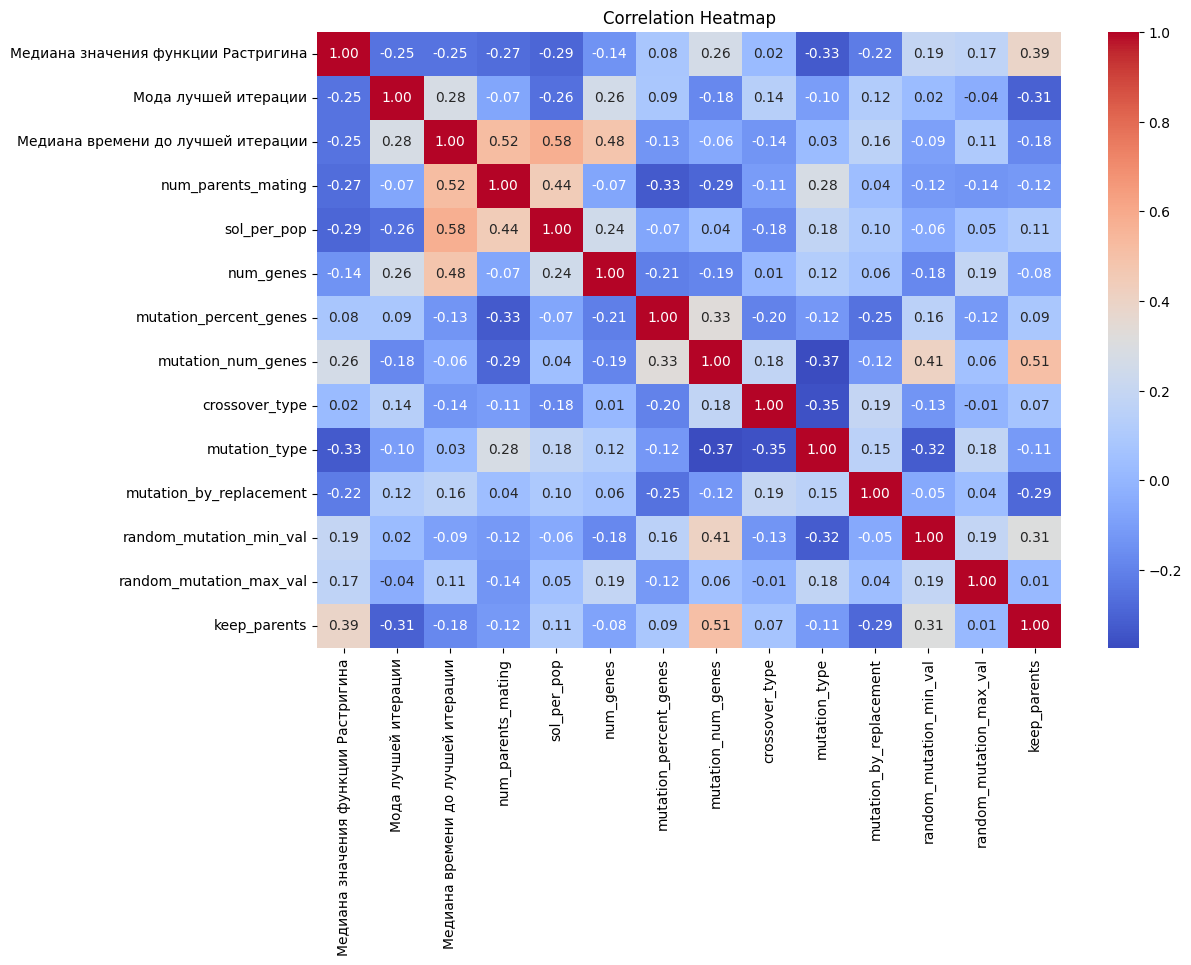

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


df = df_summary.copy()


# Функция для кодирования столбца 'mutation_num_genes'
def encode_mutation_num_genes(value):
    if isinstance(value, np.ndarray):
        return sum(value)  # Сумма элементов массива
    elif isinstance(value, str) and value.startswith('['):  # Если строка с массивом
        return sum(map(int, value[1:-1].split()))  # Преобразуем в массив и суммируем
    else:
        return int(value)  # Если одиночное значение



# Применяем функцию для кодирования столбца 'mutation_num_genes'
df['mutation_num_genes'] = df['mutation_num_genes'].apply(encode_mutation_num_genes)

# Преобразуем категориальные переменные в числовые с помощью кодирования
df['crossover_type'] = df['crossover_type'].astype('category').cat.codes
df['mutation_type'] = df['mutation_type'].astype('category').cat.codes
df['mutation_by_replacement'] = df['mutation_by_replacement'].astype(int)  # True/False в 1/0

# Рассчитываем корреляционную матрицу
correlation_matrix = df.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
